<a href="https://colab.research.google.com/github/highonhues/House_Price_ML_Project/blob/analysis/HousePrice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ML and Dashboard Project

The dataset has 1 CSV file with 10 columns -

* realtor-data.csv (2,226,382 entries)
* brokered by (categorically encoded agency/broker)
* status (Housing status - a. ready for sale or b. ready to build)
* price (Housing price, it is either the current listing price or recently sold * price if the house is sold recently)
* bed (# of beds)
* bath (# of bathrooms)
* acre_lot (Property / Land size in acres)
* street (categorically encoded street address)
* city (city name)
* state (state name)
* zip_code (postal code of the area)
* house_size (house area/size/living space in square feet)
* prev_sold_date (Previously sold date)

NB:

brokered by and street addresses were categorically encoded due to privacy policy  
acre_lot means the total land area, and house_size denotes the living space/building area

In [90]:
#library to help handle us based data
!pip install us

In [91]:
import folium
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
import us
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

In [92]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [93]:
file_name = 'drive/MyDrive/realtor-data.csv'
#file_name = 'realtor-data.zip.csv'
data = pd.read_csv(file_name)

##EDA

In [94]:
data.shape

(2226382, 12)

In [95]:
data.head(10)

brokered_by    status     price  bed  bath  acre_lot     street  \
0     103378.0  for_sale  105000.0  3.0   2.0      0.12  1962661.0   
1      52707.0  for_sale   80000.0  4.0   2.0      0.08  1902874.0   
2     103379.0  for_sale   67000.0  2.0   1.0      0.15  1404990.0   
3      31239.0  for_sale  145000.0  4.0   2.0      0.10  1947675.0   
4      34632.0  for_sale   65000.0  6.0   2.0      0.05   331151.0   
5     103378.0  for_sale  179000.0  4.0   3.0      0.46  1850806.0   
6       1205.0  for_sale   50000.0  3.0   1.0      0.20  1298094.0   
7      50739.0  for_sale   71600.0  3.0   2.0      0.08  1048466.0   
8      81909.0  for_sale  100000.0  2.0   1.0      0.09   734904.0   
9      65672.0  for_sale  300000.0  5.0   3.0      7.46  1946226.0   

            city        state  zip_code  house_size prev_sold_date  
0       Adjuntas  Puerto Rico     601.0       920.0            NaN  
1       Adjuntas  Puerto Rico     601.0      1527.0            NaN  
2     Juana Diaz  Puerto Rico     795.0       748.0            NaN  
3          Ponce  Puerto Rico     731.0      1800.0            NaN  
4       Mayaguez  Puerto Rico     680.0         NaN            NaN  
5  San Sebastian  Puerto Rico     612.0      2520.0            NaN  
6         Ciales  Puerto Rico     639.0      2040.0            NaN  
7          Ponce  Puerto Rico     731.0      1050.0            NaN  
8          Ponce  Puerto Rico     730.0      1092.0            NaN  
9     Las Marias  Puerto Rico     670.0      5403.0            NaN

In [96]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2226382 entries, 0 to 2226381
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   brokered_by     float64
 1   status          object 
 2   price           float64
 3   bed             float64
 4   bath            float64
 5   acre_lot        float64
 6   street          float64
 7   city            object 
 8   state           object 
 9   zip_code        float64
 10  house_size      float64
 11  prev_sold_date  object 
dtypes: float64(8), object(4)
memory usage: 203.8+ MB


In [97]:
#The true values show the NaN values in that col
for feature in data.columns:
    print(data[feature].isna().value_counts("True"), "\n")

brokered_by
False    0.997964
True     0.002036
Name: proportion, dtype: float64 

status
False    1.0
Name: proportion, dtype: float64 

price
False    0.999308
True     0.000692
Name: proportion, dtype: float64 

bed
False    0.783812
True     0.216188
Name: proportion, dtype: float64 

bath
False    0.770133
True     0.229867
Name: proportion, dtype: float64 

acre_lot
False    0.853759
True     0.146241
Name: proportion, dtype: float64 

street
False    0.995119
True     0.004881
Name: proportion, dtype: float64 

city
False    0.999368
True     0.000632
Name: proportion, dtype: float64 

state
False    0.999996
True     0.000004
Name: proportion, dtype: float64 

zip_code
False    0.999866
True     0.000134
Name: proportion, dtype: float64 

house_size
False    0.74466
True     0.25534
Name: proportion, dtype: float64 

prev_sold_date
False    0.670184
True     0.329816
Name: proportion, dtype: float64 



There is a lot of missing value for house_size, prev_sold_date, bed, bath, acre_lot. We will consider imputing strategy for these features.

The other features have very small proportion of missing values. We can consider dropping strategy for these features. Brokered_by and street are categorically encoded and we don't know how we will not use them further.

In [98]:
data.dropna(subset=["brokered_by", "price", "street", "city", "state", "zip_code"], inplace=True)
data.drop(columns=["brokered_by","street"], inplace=True)

In [99]:
for feature in data.columns:
    print(feature, data[feature].nunique())

status 3
price 101530
bed 99
bath 86
acre_lot 15841
city 19675
state 55
zip_code 30251
house_size 12018
prev_sold_date 14937


Q. How have prices of houses that are getting sold changed through the years based on house size?

In [100]:
#add a year columns
solddf = data[data['status'] == "sold"].copy()
solddf["year"] = solddf.prev_sold_date.str.split("-").str[0]

solddf["year"].unique()

array(['2021', '2022', '3019'], dtype=object)

The data we have isn't really helpful for doing an analysis based on sold status. Also what even is the year 3019? Maybe we can focus our analysis just on price change based on year irrespective of status.

In [101]:
yeardf = data.copy()
yeardf["year"] = yeardf.prev_sold_date.str.split("-").str[0]
yeardf.year.unique()

array([nan, '2020', '2019', '2021', '2013', '2018', '2016', '2010',
       '2022', '2014', '2012', '1997', '1986', '2008', '2005', '1992',
       '1996', '1993', '1998', '2006', '1988', '2004', '2001', '2009',
       '2007', '2011', '2000', '2017', '2002', '2003', '1989', '2015',
       '1991', '1990', '1999', '1987', '1984', '1994', '1979', '1995',
       '1981', '1980', '1978', '1982', '1983', '1985', '1973', '1968',
       '1910', '1901', '1966', '1974', '1976', '1975', '1971', '1977',
       '1961', '1972', '1970', '1965', '1952', '1957', '1964', '1955',
       '1967', '1963', '1962', '1969', '1953', '1956', '1960', '2023',
       '1954', '1909', '1935', '1958', '1959', '1928', '1950', '1941',
       '1926', '2024', '2026', '1951', '1939', '1904', '1949', '1905',
       '1906', '3019'], dtype=object)

I have nan values here for year. However, I dont want to mess up my year so I will fill up these with a placeholder value in place of dropping them to see if there is any interesting pattern in the houses where there is no year.

In [102]:
yeardf['year'] = yeardf['year'].fillna('1111')
yeardf['year'] = pd.to_numeric(yeardf['year'], errors='coerce') #convert to numeric values

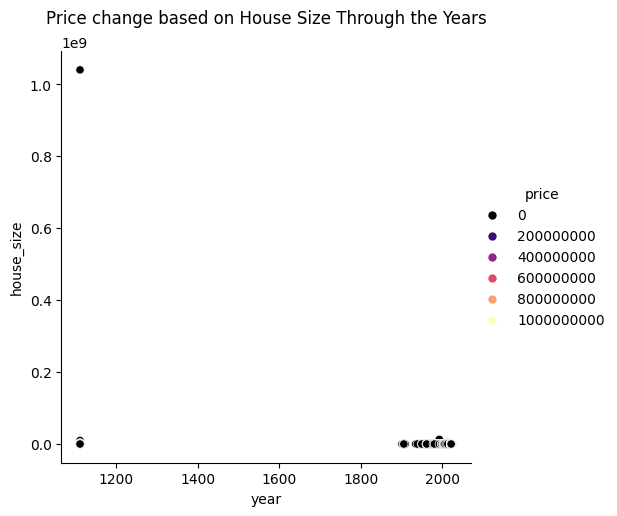

In [ ]:
#plotly gave up hence sns

sns.relplot(
    data=yeardf[yeardf.year <= 2024],
    x="year",
    y="house_size",
    hue="price",
    palette ="magma"

)

plt.title("Price change based on House Size Through the Years", pad=20);
 #pad=20, allow a bit more space for a two-line title

Looks...interesting. We will come back to this.

Before proceeding, this dataset is way to big for us. We will try to stratify split this based on state.

In [162]:
state_proportions = data['state'].value_counts() / len(data)

fig = px.bar(state_proportions.reset_index().sort_values(by='count', ascending=False), x='state', y='count'
             ,title='Proportion of Houses by State')
fig.show()

In [164]:
use = data[data["state"]
           != "New Brunswick"].reset_index(drop=True)
use

status     price  bed  bath  acre_lot        city        state  \
0        for_sale  105000.0  3.0   2.0      0.12    Adjuntas  Puerto Rico   
1        for_sale   80000.0  4.0   2.0      0.08    Adjuntas  Puerto Rico   
2        for_sale   67000.0  2.0   1.0      0.15  Juana Diaz  Puerto Rico   
3        for_sale  145000.0  4.0   2.0      0.10       Ponce  Puerto Rico   
4        for_sale   65000.0  6.0   2.0      0.05    Mayaguez  Puerto Rico   
...           ...       ...  ...   ...       ...         ...          ...   
2207975      sold  359900.0  4.0   2.0      0.33    Richland   Washington   
2207976      sold  350000.0  3.0   2.0      0.10    Richland   Washington   
2207977      sold  440000.0  6.0   3.0      0.50    Richland   Washington   
2207978      sold  179900.0  2.0   1.0      0.09    Richland   Washington   
2207979      sold  580000.0  5.0   3.0      0.31    Richland   Washington   

         zip_code  house_size prev_sold_date  
0           601.0       920.0            NaN  
1           601.0      1527.0            NaN  
2           795.0       748.0            NaN  
3           731.0      1800.0            NaN  
4           680.0         NaN            NaN  
...           ...         ...            ...  
2207975   99354.0      3600.0     2022-03-25  
2207976   99354.0      1616.0     2022-03-25  
2207977   99354.0      3200.0     2022-03-24  
2207978   99354.0       933.0     2022-03-24  
2207979   99354.0      3615.0     2022-03-23  

[2207980 rows x 10 columns]

In [172]:
split_small = StratifiedShuffleSplit(n_splits=1, test_size=0.7, random_state=42)

#the least populated class in state has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
for firsthalf_index, secondhalf_index in split_small.split(use, use["state"]):
    firsthalf = use.loc[firsthalf_index].reset_index(drop=True)
    secondhalf = use.loc[secondhalf_index].reset_index(drop=True)

In [166]:
df = firsthalf.copy()

In [167]:
df.shape

(662394, 10)

Since there is so many unique values for bed and bath. We suspect that there must be some issues with it (mistyped, wrong format)

In [ ]:
px.scatter(
    df,
    x="bed",
    y="bath",
    title="Number of bed and number of bath correlation",
)
fig = px.scatter(
    df[["bed", "bath"]].value_counts().reset_index(),
    x="bed",
    y="bath",
    color="count",
    title="Number of bed and number of bath correlation",

)
fig.update_traces(marker={'size': 15})

Based on the graph, we can see that there are a lot of unrealistic values for both beds and baths. There are even house with 1 bed and 460 bathrooms. Moreover, this dataset is collected from a real estate website. We can safely say that office and buildings may not be included in this dataset. Hence, we assume that a house generally, only has maximum of 9 beds and 9 baths.

Strategy: Format values for bed and bath to only take the first digit of the value (e.g: 333 baths = 3 baths). Exclude 0 values for both baths and beds. Moreover, a house cannot have more bathrooms than bedrooms. However, we assume the relationship that the difference between bed no. and bath no. must be <= (bed no. / 2).

In [107]:
# Cleaning bed and bath mistype.
def clean_bed_and_bath(data):
    def clean_data(x):
        while x >= 10:
            x = x // 10
        return x

    data["bed"] = data["bed"].apply(clean_data)
    data["bath"] = data["bath"].apply(clean_data)
    data = data[(np.abs(data["bed"] - data["bath"]) <= (data["bed"] / 2))]
    return data


bed_bath_cleaner = FunctionTransformer(clean_bed_and_bath)
bed_bath_cleaner.fit_transform(df)

status     price  bed  bath  acre_lot           city       state  \
0           sold  700900.0  2.0   2.0      2.88       Carlsbad  California   
1           sold  798000.0  2.0   2.0       NaN      San Diego  California   
2       for_sale  849000.0  3.0   3.0      0.04  Mission Viejo  California   
3       for_sale  579900.0  3.0   2.0      5.01    Grants Pass      Oregon   
4       for_sale   59000.0  2.0   1.0      0.16         Neligh    Nebraska   
...          ...       ...  ...   ...       ...            ...         ...   
662385      sold  410000.0  3.0   2.0      0.15         Dallas       Texas   
662386  for_sale  174900.0  3.0   2.0      1.00    Mooresville     Indiana   
662387      sold  189900.0  2.0   2.0      0.23     Beaver Dam   Wisconsin   
662388      sold  187500.0  2.0   2.0      0.22      Inverness     Florida   
662389  for_sale  399900.0  3.0   3.0      0.08    Saint Louis    Missouri   

        zip_code  house_size prev_sold_date  
0        92009.0      1515.0     2022-02-15  
1        92130.0      1193.0     2022-01-31  
2        92692.0      1525.0     1997-05-06  
3        97526.0      2001.0     1992-08-01  
4        68756.0      1018.0            NaN  
...          ...         ...            ...  
662385   75204.0      1386.0     2022-01-05  
662386   46158.0      2195.0            NaN  
662387   53916.0      1392.0     2022-03-18  
662388   34452.0       960.0     2022-02-07  
662389   63104.0      2328.0     2022-02-07  

[465461 rows x 10 columns]

In [140]:
house = bed_bath_cleaner.fit_transform(df)

house.reset_index(drop=True)

status     price  bed  bath  acre_lot           city       state  \
0           sold  700900.0  2.0   2.0      2.88       Carlsbad  California   
1           sold  798000.0  2.0   2.0       NaN      San Diego  California   
2       for_sale  849000.0  3.0   3.0      0.04  Mission Viejo  California   
3       for_sale  579900.0  3.0   2.0      5.01    Grants Pass      Oregon   
4       for_sale   59000.0  2.0   1.0      0.16         Neligh    Nebraska   
...          ...       ...  ...   ...       ...            ...         ...   
465456      sold  410000.0  3.0   2.0      0.15         Dallas       Texas   
465457  for_sale  174900.0  3.0   2.0      1.00    Mooresville     Indiana   
465458      sold  189900.0  2.0   2.0      0.23     Beaver Dam   Wisconsin   
465459      sold  187500.0  2.0   2.0      0.22      Inverness     Florida   
465460  for_sale  399900.0  3.0   3.0      0.08    Saint Louis    Missouri   

        zip_code  house_size prev_sold_date  
0        92009.0      1515.0     2022-02-15  
1        92130.0      1193.0     2022-01-31  
2        92692.0      1525.0     1997-05-06  
3        97526.0      2001.0     1992-08-01  
4        68756.0      1018.0            NaN  
...          ...         ...            ...  
465456   75204.0      1386.0     2022-01-05  
465457   46158.0      2195.0            NaN  
465458   53916.0      1392.0     2022-03-18  
465459   34452.0       960.0     2022-02-07  
465460   63104.0      2328.0     2022-02-07  

[465461 rows x 10 columns]

The plot is to big for us to plot the distribution of house_size and acre_lot. However, assume that the data is a random sample. The size is 465,461 is large enough to apply Central Limit Theory to assume the normal distribution.

array([[<Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'bed'}>],
       [<Axes: title={'center': 'bath'}>,
        <Axes: title={'center': 'acre_lot'}>],
       [<Axes: title={'center': 'zip_code'}>,
        <Axes: title={'center': 'house_size'}>]], dtype=object)

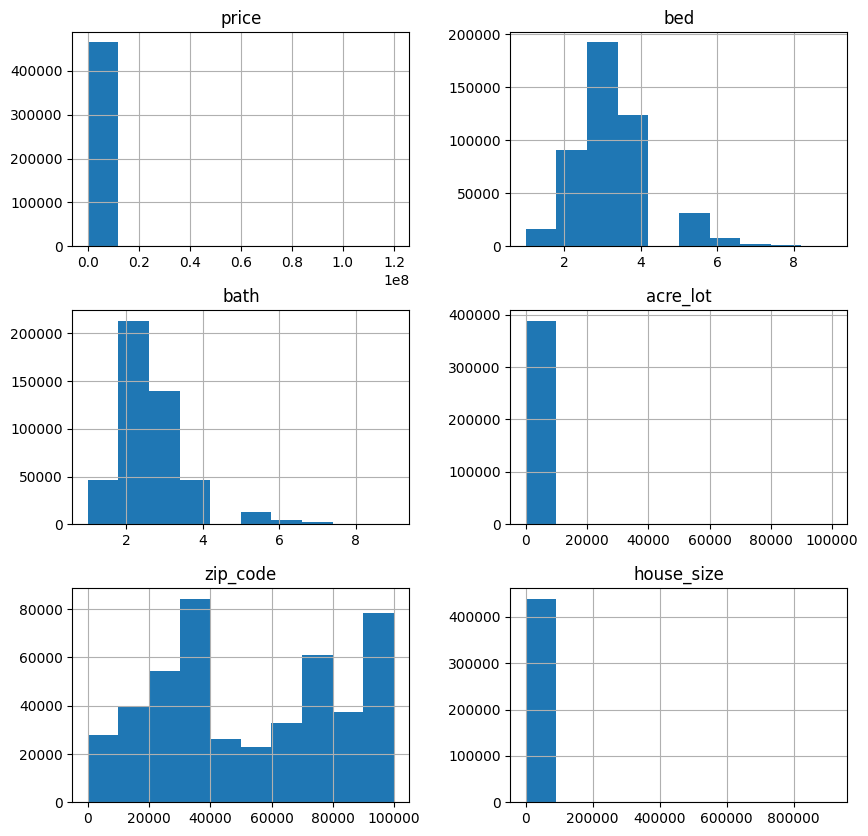

In [ ]:
house.hist(figsize=(10,10))

In [ ]:
normalizator = StandardScaler()
house[["acre_lot", "house_size"]] = normalizator.fit_transform(house[["acre_lot", "house_size"]])

<ipython-input-20-08c901b55913>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Coming back to our house price question let use try to use the smaller house df to continue our analysis.

In [47]:
year_h = house.copy()
year_h["year"] = year_h.prev_sold_date.str.split("-").str[0]
year_h.year.unique()

year_h['year'] = year_h['year'].fillna('1111')
year_h['year'] = pd.to_numeric(year_h['year'], errors='coerce') #convert to numeric values

<Figure size 900x600 with 0 Axes>

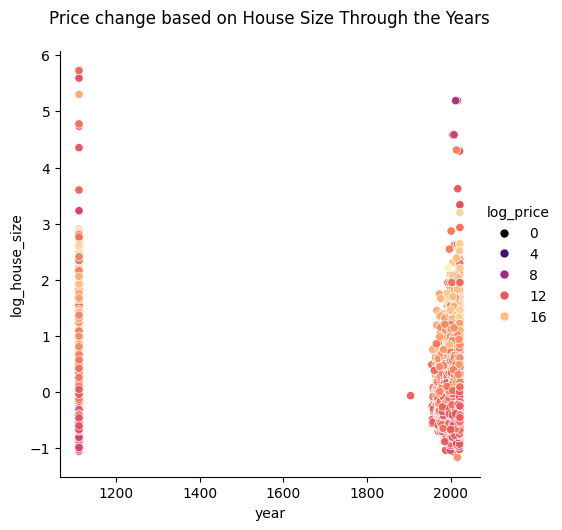

In [ ]:
#plotly gave up hence sns
plot_df = year_h.copy()

# Apply a logarithmic transformation to 'price' and 'house_size' to handle wide ranges
# Adding a small value (1) to avoid taking log of zero
plot_df['log_price'] = np.log(plot_df['price'] + 1)
plot_df['log_house_size'] = np.log(plot_df['house_size'] + 1)
plt.figure(figsize=(9,6))

sns.relplot(
    data=plot_df[plot_df.year <= 2024],
    x="year",
    y="log_house_size",
    hue="log_price",
    palette ="magma"

);

plt.title("Price change based on House Size Through the Years", pad=20);
 #pad=20, allow a bit more space for a two-line title

Mostly low price size is present. Ill try to see without 1111

<Figure size 900x600 with 0 Axes>

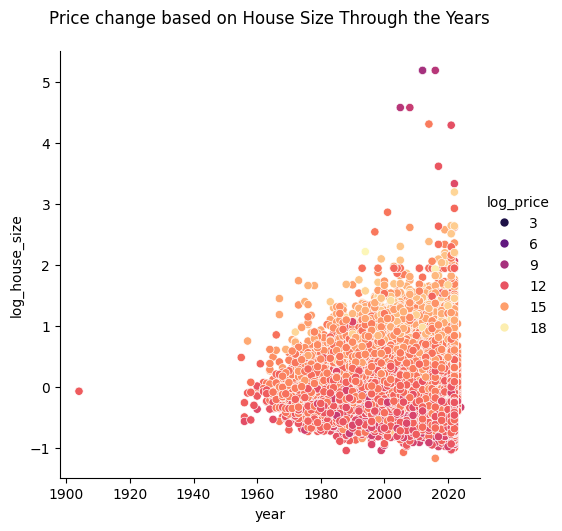

In [ ]:
#plotly gave up hence sns
plot_df = year_h.copy()

# Apply a logarithmic transformation to 'price' and 'house_size' to handle wide ranges
# Adding a small value (1) to avoid taking log of zero
plot_df['log_price'] = np.log(plot_df['price'] + 1)
plot_df['log_house_size'] = np.log(plot_df['house_size'] + 1)
plt.figure(figsize=(9,6))

sns.relplot(
    data=plot_df[(plot_df.year <= 2024) & (plot_df.year>= 1200)],
    x="year",
    y="log_house_size",
    hue="log_price",
    palette ="magma"

);

plt.title("Price change based on House Size Through the Years", pad=20);
 #pad=20, allow a bit more space for a two-line title

In [ ]:
for feature in house.columns:
    print(feature, house[feature].isna().value_counts())

status status
False    465461
Name: count, dtype: int64
price price
False    465461
Name: count, dtype: int64
bed bed
False    465461
Name: count, dtype: int64
bath bath
False    465461
Name: count, dtype: int64
acre_lot acre_lot
False    388678
True      76783
Name: count, dtype: int64
city city
False    465461
Name: count, dtype: int64
state state
False    465461
Name: count, dtype: int64
zip_code zip_code
False    465461
Name: count, dtype: int64
house_size house_size
False    439320
True      26141
Name: count, dtype: int64
prev_sold_date prev_sold_date
False    361834
True     103627
Name: count, dtype: int64


In [ ]:
# Cleaning bed and bath mistype.
def clean_bed_and_bath(data):
    def clean_data(x):
        while x >= 10:
            x = x // 10
        return x

    data["bed"] = data["bed"].apply(clean_data)
    data["bath"] = data["bath"].apply(clean_data)
    data = data[(np.abs(data["bed"] - data["bath"]) <= (data["bed"] / 2))]
    return data


bed_bath_cleaner = FunctionTransformer(clean_bed_and_bath)
bed_bath_cleaner.fit_transform(house)

<ipython-input-25-ba3c6d7b14c7>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-25-ba3c6d7b14c7>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



status     price  bed  bath  acre_lot           city       state  \
0           sold  700900.0  2.0   2.0 -0.011642       Carlsbad  California   
1           sold  798000.0  2.0   2.0       NaN      San Diego  California   
2       for_sale  849000.0  3.0   3.0 -0.015247  Mission Viejo  California   
3       for_sale  579900.0  3.0   2.0 -0.008937    Grants Pass      Oregon   
4       for_sale   59000.0  2.0   1.0 -0.015095         Neligh    Nebraska   
...          ...       ...  ...   ...       ...            ...         ...   
662385      sold  410000.0  3.0   2.0 -0.015107         Dallas       Texas   
662386  for_sale  174900.0  3.0   2.0 -0.014028    Mooresville     Indiana   
662387      sold  189900.0  2.0   2.0 -0.015006     Beaver Dam   Wisconsin   
662388      sold  187500.0  2.0   2.0 -0.015018      Inverness     Florida   
662389  for_sale  399900.0  3.0   3.0 -0.015196    Saint Louis    Missouri   

        zip_code  house_size prev_sold_date  
0        92009.0   -0.181481     2022-02-15  
1        92130.0   -0.289619     2022-01-31  
2        92692.0   -0.178122     1997-05-06  
3        97526.0   -0.018266     1992-08-01  
4        68756.0   -0.348389            NaN  
...          ...         ...            ...  
662385   75204.0   -0.224803     2022-01-05  
662386   46158.0    0.046886            NaN  
662387   53916.0   -0.222788     2022-03-18  
662388   34452.0   -0.367868     2022-02-07  
662389   63104.0    0.091552     2022-02-07  

[465461 rows x 10 columns]

In [ ]:
house[["bed", "bath"]].isna().value_counts()

bed    bath 
False  False    465461
Name: count, dtype: int64

This is the dataset that fits our assumptions perfectly. However, it excluded all the nan values of beds and baths. We will use this dataset to train linear regression model to impute bed and bath for the original dataset.


###Untouched from eddie's ver
---



ZIP code cannot tell the exact state so we want to transform state to abbr for plotting with folium. Then create an fips column for training the model. We cannot find the geojson file that contain location of state fips to use with folium. State abbr will be drop later.

In [ ]:
def state_transformer(data):
  map = us.states.mapping('abbr', 'fips')
  def name_to_abbr(state_name):
    state = us.states.lookup(state_name)
    if state:
        return state.abbr
    else:
        return "Unknown"

  def abbr_to_fips(x):

    if x in map:
      return map[x]
    return 0
  data["state"] = data["state"].apply(name_to_abbr)
  data["fips"] = data["state"].apply(abbr_to_fips)
  return data


state_convert = FunctionTransformer(state_transformer)
state_convert.fit_transform(data)

status     price  bed  bath  acre_lot        city state  zip_code  \
0        for_sale  105000.0  3.0   2.0      0.12    Adjuntas    PR     601.0   
1        for_sale   80000.0  4.0   2.0      0.08    Adjuntas    PR     601.0   
2        for_sale   67000.0  2.0   1.0      0.15  Juana Diaz    PR     795.0   
3        for_sale  145000.0  4.0   2.0      0.10       Ponce    PR     731.0   
4        for_sale   65000.0  6.0   2.0      0.05    Mayaguez    PR     680.0   
...           ...       ...  ...   ...       ...         ...   ...       ...   
2226377      sold  359900.0  4.0   2.0      0.33    Richland    WA   99354.0   
2226378      sold  350000.0  3.0   2.0      0.10    Richland    WA   99354.0   
2226379      sold  440000.0  6.0   3.0      0.50    Richland    WA   99354.0   
2226380      sold  179900.0  2.0   1.0      0.09    Richland    WA   99354.0   
2226381      sold  580000.0  5.0   3.0      0.31    Richland    WA   99354.0   

         house_size prev_sold_date fips  
0             920.0            NaN   72  
1            1527.0            NaN   72  
2             748.0            NaN   72  
3            1800.0            NaN   72  
4               NaN            NaN   72  
...             ...            ...  ...  
2226377      3600.0     2022-03-25   53  
2226378      1616.0     2022-03-25   53  
2226379      3200.0     2022-03-24   53  
2226380       933.0     2022-03-24   53  
2226381      3615.0     2022-03-23   53  

[2207981 rows x 11 columns]

Q. Average house price by state in the original dataset

In [ ]:
import requests

state_mean = data.groupby("state")["price"].mean().reset_index()
us_states = requests.get(
    "https://raw.githubusercontent.com/python-visualization/folium-example-data/main/us_states.json"
).json()

state_mean = state_mean[state_mean["state"] != "Unknown"]
m = folium.Map([43, -100], zoom_start=4, title="Average price by state")

folium.Choropleth(
    geo_data=us_states,
    data=state_mean,
    columns=["state", "price"],
    key_on="feature.id",

).add_to(m)
m

The distribution of price by state is big. There is huge difference between the average price by state.

Next, we will encode listing status data

In [ ]:
house.status.value_counts()

status
for_sale    265017
sold        200444
Name: count, dtype: int64

Since there is only 2 types of status, we can use one-hot encoding for this one.

In [ ]:
# Use get dummies for
encoder = OneHotEncoder(sparse=False, drop="first")
status_encoded = encoder.fit_transform(house[['status']])

status_df = pd.DataFrame(status_encoded, columns=encoder.get_feature_names_out(['status']))
transformed_data = pd.concat([house.drop(columns=['status']), status_df], axis=1)
house = transformed_data.dropna(subset="state")

# Use OneHotEncoder in pipeline
house

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



price  bed  bath  acre_lot           city       state  zip_code  \
0       700900.0  2.0   2.0      2.88       Carlsbad  California   92009.0   
1       798000.0  2.0   2.0       NaN      San Diego  California   92130.0   
2       849000.0  3.0   3.0      0.04  Mission Viejo  California   92692.0   
3       579900.0  3.0   2.0      5.01    Grants Pass      Oregon   97526.0   
4        59000.0  2.0   1.0      0.16         Neligh    Nebraska   68756.0   
...          ...  ...   ...       ...            ...         ...       ...   
662385  410000.0  3.0   2.0      0.15         Dallas       Texas   75204.0   
662386  174900.0  3.0   2.0      1.00    Mooresville     Indiana   46158.0   
662387  189900.0  2.0   2.0      0.23     Beaver Dam   Wisconsin   53916.0   
662388  187500.0  2.0   2.0      0.22      Inverness     Florida   34452.0   
662389  399900.0  3.0   3.0      0.08    Saint Louis    Missouri   63104.0   

        house_size prev_sold_date  status_sold  
0           1515.0     2022-02-15          1.0  
1           1193.0     2022-01-31          1.0  
2           1525.0     1997-05-06          0.0  
3           2001.0     1992-08-01          0.0  
4           1018.0            NaN          0.0  
...            ...            ...          ...  
662385      1386.0     2022-01-05          NaN  
662386      2195.0            NaN          NaN  
662387      1392.0     2022-03-18          NaN  
662388       960.0     2022-02-07          NaN  
662389      2328.0     2022-02-07          NaN  

[465461 rows x 10 columns]

<Axes: >

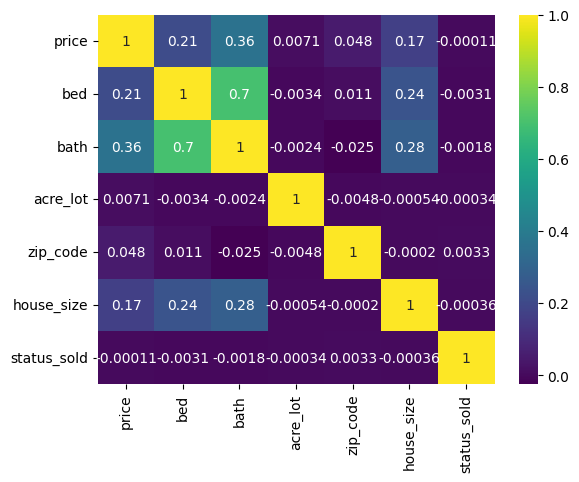

In [56]:
all_numeric = house.drop(columns=["state", "city", 'prev_sold_date'])
# all_numeric['prev_sold_date'] = pd.to_datetime(all_numeric["prev_sold_date"])
correlation = all_numeric.corr()
sns.heatmap(
    data=correlation,
    cmap='viridis',
    annot = True
)



---

### Machine Learning

First let's make the pipeline to process all the data

In [174]:
firsthalf

status      price  bed  bath  acre_lot           city  \
0           sold   700900.0  2.0   2.0      2.88       Carlsbad   
1           sold   798000.0  2.0   2.0       NaN      San Diego   
2       for_sale   849000.0  3.0   3.0      0.04  Mission Viejo   
3       for_sale   579900.0  3.0   2.0      5.01    Grants Pass   
4       for_sale    59000.0  2.0   1.0      0.16         Neligh   
...          ...        ...  ...   ...       ...            ...   
662389  for_sale   399900.0  3.0   3.0      0.08    Saint Louis   
662390  for_sale    75000.0  NaN   NaN      0.17     High Point   
662391  for_sale    69900.0  3.0   1.0      3.96        Nekoosa   
662392  for_sale    73000.0  NaN   NaN      0.31         Blanco   
662393  for_sale  2000000.0  NaN   NaN     10.00      Fort Mill   

                 state  zip_code  house_size prev_sold_date  
0           California   92009.0      1515.0     2022-02-15  
1           California   92130.0      1193.0     2022-01-31  
2           California   92692.0      1525.0     1997-05-06  
3               Oregon   97526.0      2001.0     1992-08-01  
4             Nebraska   68756.0      1018.0            NaN  
...                ...       ...         ...            ...  
662389        Missouri   63104.0      2328.0     2022-02-07  
662390  North Carolina   27262.0         NaN            NaN  
662391       Wisconsin   54457.0      1200.0     2006-10-18  
662392           Texas   78606.0         NaN            NaN  
662393  South Carolina   29708.0         NaN     1996-07-15  

[662394 rows x 10 columns]

Predicting house price is a regression problem. To prevent data leaking feature engineering is performed separately for train and test.

In [173]:
firsthalf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 662394 entries, 0 to 662393
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          662394 non-null  object 
 1   price           662394 non-null  float64
 2   bed             519740 non-null  float64
 3   bath            510886 non-null  float64
 4   acre_lot        565746 non-null  float64
 5   city            662394 non-null  object 
 6   state           662394 non-null  object 
 7   zip_code        662394 non-null  float64
 8   house_size      494006 non-null  float64
 9   prev_sold_date  444540 non-null  object 
dtypes: float64(6), object(4)
memory usage: 50.5+ MB


In [175]:
firsthalf.isna().sum()/len(df)

status            0.000000
price             0.000000
bed               0.215361
bath              0.228728
acre_lot          0.145907
city              0.000000
state             0.000000
zip_code          0.000000
house_size        0.254211
prev_sold_date    0.328889
dtype: float64

Stratifies split this again based on state for train and test.

In [176]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(ml_df, ml_df["state"]):
    strat_train_set = ml_df.loc[train_index]
    strat_test_set = ml_df.loc[test_index]


# Let's separate the predictors and the labels since we don't necessarily want to apply
# the same transformations to the predictors and the target values.
# Let's create a copy of the data and not affect strat_train_set:
estate_train = strat_train_set.drop(columns=["price"], axis=1) # drop labels for training set
estate_labels = strat_train_set["price"].copy()

In [178]:
estate_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 372368 entries, 149428 to 39807
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   status      372368 non-null  object 
 1   bed         372368 non-null  float64
 2   bath        372368 non-null  float64
 3   acre_lot    311013 non-null  float64
 4   city        372368 non-null  object 
 5   state       372368 non-null  object 
 6   zip_code    372368 non-null  float64
 7   house_size  351403 non-null  float64
 8   year_sold   289389 non-null  object 
dtypes: float64(5), object(4)
memory usage: 28.4+ MB


In [ ]:
# 1. Handle numerical attributes

#bed and bath and drop city and year

def clean_bed_and_bath(data):
    def clean_data(x):
        while x >= 10:
            x = x // 10
        return x

    data["bed"] = data["bed"].apply(clean_data)
    data["bath"] = data["bath"].apply(clean_data)
    data = data[(np.abs(data["bed"] - data["bath"]) <= (data["bed"] / 2))]
    # data.drop(columns=(["prev_year_sold","city"]),inplace = True) #we already have location data from zipcode
    return data

bed_bath_cleaner = FunctionTransformer(clean_bed_and_bath)
estate_train_bb = bed_bath_cleaner.fit_transform(estate_train)

#housing size, acre lot

# imputer = SimpleImputer(strategy="median")
# eti = estate_train[estate_train["acre_lot","housing_size"]].copy()
# estate_tr_ac_hs = imputer.fit_transform(eti)

# imputation transformer
trf1 = ColumnTransformer([,
    ('encoder',SimpleImputer(strategy="median"),[3,7])
])

####################

# 2. Handle text/categorical attributes

#status
encoder = OneHotEncoder(sparse=False, drop="first")
ets = estate_train[['status']]
estate_train_1hot = encoder.fit_transform(ets)

#zipcode
def abbr_to_fips(x):

  if x in map:
    return map[x]
  return 0
data["state"] = data["state"].apply(name_to_abbr)
data["fips"] = data["state"].apply(abbr_to_fips)
return data

state_convert = FunctionTransformer(state_transformer)
estate_train_z = state_convert.fit_transform(data)

trf2 = ColumnTransformer([('log',FunctionTransformer(np.log1p),['Fare'])],remainder='passthrough')


##################
# status_df = pd.DataFrame(status_encoded, columns=encoder.get_feature_names_out(['status']))
# transformed_data = pd.concat([house.drop(columns=['status']), status_df], axis=1)
# house = transformed_data.dropna(subset="state")

# # Use OneHotEncoder in pipeline
# house
#####################

###################################
#### Put together the pipeline ####
###################################


# little_pipe = ColumnTransformer([
#     ("status_encode", OneHotEncoder(handle_unknown="ignore", drop='first'), ["status"]),
#     ("normalization", StandardScaler(), ["acre_lot", "house_size"]),
#   ], remainder='passthrough')

# pipeline = Pipeline([
#     ("bed_bath_clean", bed_bath_cleaner),
#     ("state_encode", state_convert),
#     ("unused_columns_drop", drop_unused),
#     ("column_transform", little_pipe),
#     ("fill_na", SimpleImputer(strategy="most_frequent"))
# ])


################


# Pipeline for numerical attributes
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")), # fill in missing values with median values
        ('bed_bath_cleaner', bed_bath_cleaner()),  # add combined attributes to the data

    ])

#cat pipeline
cat_pipeline = Pipeline([
        (('state_convert', state_convert())),
        ('encoder', OneHotEncoder(sparse=False, drop="first")),

    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)


# Complete the pipeline with combine categorical attributes
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)
cols=list(housing.columns) + ["rooms_per_household", "population_per_household"] + \
    cat_encoder.categories_[0].tolist()

## Convert the 2D array into Pandas DataFrame
housing_prep_df = pd.DataFrame(
    housing_prepared,
    columns=cols,
    index=housing.index)
housing_prep_df.head()

In [ ]:
def get_scores(true_y, pred_y, model_name, all_performances):
    all_performances['model_name'].append(model_name)
    all_performances['MAE'].append(mean_absolute_error(true_y, pred_y))
    all_performances['MSE'].append(mean_squared_error(true_y, pred_y))
    all_performances['R2-Score'].append(r2_score(true_y, pred_y

A huge chunk of the entries are null for house_size, acre_lot, bed, bath and year_sold. We will have to impute or drop. The year is too big a percentage and a categorical variable. We will drop it.

In [171]:
firsthalf.drop(columns=["prev_sold_date"])

status      price  bed  bath  acre_lot           city  \
0           sold   700900.0  2.0   2.0      2.88       Carlsbad   
1           sold   798000.0  2.0   2.0       NaN      San Diego   
2       for_sale   849000.0  3.0   3.0      0.04  Mission Viejo   
3       for_sale   579900.0  3.0   2.0      5.01    Grants Pass   
4       for_sale    59000.0  2.0   1.0      0.16         Neligh   
...          ...        ...  ...   ...       ...            ...   
662389  for_sale   399900.0  3.0   3.0      0.08    Saint Louis   
662390  for_sale    75000.0  NaN   NaN      0.17     High Point   
662391  for_sale    69900.0  3.0   1.0      3.96        Nekoosa   
662392  for_sale    73000.0  NaN   NaN      0.31         Blanco   
662393  for_sale  2000000.0  NaN   NaN     10.00      Fort Mill   

                 state  zip_code  house_size  
0           California   92009.0      1515.0  
1           California   92130.0      1193.0  
2           California   92692.0      1525.0  
3               Oregon   97526.0      2001.0  
4             Nebraska   68756.0      1018.0  
...                ...       ...         ...  
662389        Missouri   63104.0      2328.0  
662390  North Carolina   27262.0         NaN  
662391       Wisconsin   54457.0      1200.0  
662392           Texas   78606.0         NaN  
662393  South Carolina   29708.0         NaN  

[662394 rows x 9 columns]

In [157]:
estate_train

status  bed  bath  acre_lot              city       state  zip_code  \
149428      sold  3.0   2.0      0.19             Chico  California   95928.0   
290727  for_sale  4.0   4.0      3.16        Eldersburg    Maryland   21784.0   
59997       sold  4.0   3.0      0.13        Sacramento  California   95832.0   
142300  for_sale  2.0   2.0       NaN            Denver    Colorado   80203.0   
154591      sold  3.0   2.0      0.31        Farmington    Arkansas   72730.0   
...          ...  ...   ...       ...               ...         ...       ...   
104102      sold  2.0   2.0      0.02         Roseville   Minnesota   55113.0   
251718  for_sale  2.0   2.0       NaN        Menlo Park  California   94025.0   
412620  for_sale  2.0   3.0       NaN            Denver    Colorado   80202.0   
263645      sold  4.0   3.0      0.50      Cartersville     Georgia   30120.0   
39807   for_sale  4.0   4.0      3.77  Mount Washington    Kentucky   40047.0   

        house_size year_sold  
149428      1481.0      2022  
290727      2950.0       NaN  
59997       3281.0      2022  
142300      1116.0      2018  
154591      1485.0      2022  
...            ...       ...  
104102      1022.0      2022  
251718      1250.0      2018  
412620      2629.0      2018  
263645      2808.0      2022  
39807       5312.0      2003  

[372368 rows x 9 columns]

In [161]:
estate_train.columns

Index(['status', 'bed', 'bath', 'acre_lot', 'city', 'state', 'zip_code',
       'house_size', 'year_sold'],
      dtype='object')

To see how to imput acre_lot and year I want to see its relationship to the other cols.

In [155]:
corr_train = estate_train[estate_train['bed', 'bath', 'acre_lot', 'city', 'state', 'zip_code',
       'house_size', 'year_sold']].corr()
sns.heatmap(corr_train, annot = True, cmap = 'coolwarm')

ValueError: could not convert string to float: 'sold'

In [ ]:
# def drop_column(data):
#   return data.drop(columns=["prev_sold_date","state","city"])

# drop_unused = FunctionTransformer(drop_column)

# # X = firsthalf.drop(columns=["price"], axis=1)
# # y = firsthalf.price

# #size 0.8
# X_train, X_test = train_test_split(firsthalf, test_size = 0.2, random_state=42)


# # It does not work so we will try using step by step processing


# X_train = pipeline.fit_transform(X_train)
# X_test = pipeline.fit_transform(X_test)

# target = X_train.price

In [ ]:
# from joblib import Parallel, delayed
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.linear_model import LogisticRegressionCV
# from sklearn.svm import SVR
# from sklearn.model_selection import cross_val_score


# models = {
#     "RandomForest": RandomForestRegressor(),
#     "LogisticRegression": LogisticRegressionCV(),
#     "SVC": SVR()
# }


# # Train models in parallel
# def train_model(name, model):
#     model.fit(X_train, y_train)
#     # y_pred = model.predict(X_test)
#     r2 = cross_val_score(X_train, X_test, cv=10, scoring='r2')
#     print(f"{name} R Square: {r2:.4f}")

# Parallel(n_jobs=-1)(delayed(train_model)(name, model) for name, model in models.items())